## Evaluating regression techniques for speaker characterization
### Laura Fernández Gallardo

In this notebook, I will only only concentrate on the 'non_likable' speaker characteristic (ratings from 0 to 100 given to this item of the questionnaire).

In [1]:
import io
import requests
import time # for timestamps

import numpy as np
import pandas as pd
from ast import literal_eval # parsing hp after tuner

from reg_tuning import * # my helper functions

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 2302
np.random.seed(seed)

## Load features and labels

In [3]:
path = 'https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/generated_data/'

url = path + "feats_ratings_scores_train.csv"
s = requests.get(url).content
feats_ratings_scores_train = pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "feats_ratings_scores_test.csv"
s = requests.get(url).content
feats_ratings_scores_test = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [73]:
with open(r'..\data\generated_data\feats_names.txt') as f:
    feats_names = f.readlines()
feats_names = [x.strip().strip('\'') for x in feats_names] 

with open(r'..\data\generated_data\items_names.txt') as f:
    items_names = f.readlines()
items_names = [x.strip().strip('\'') for x in items_names] 

with open(r'..\data\generated_data\traits_names.txt') as f:
    traits_names = f.readlines()
traits_names = [x.strip().strip('\'') for x in traits_names] 

## Model tuning with feature selection

As done for classification, I perform nested hyperparameter tuning with feature selection.

* Feature selection: SelectKBest(f_regression), tuning k
* RandomizedSearchCV on hyperparameters with uniform distribution, instead of grid search
* metric: neg_mean_squared_error


In [ ]:
# Standardize speech features  

dropcolumns = ['name','spkID','speaker_gender'] + items_names + traits_names

# learn transformation on training data
scaler = StandardScaler()
scaler.fit(feats_ratings_scores_train.drop(dropcolumns, axis=1))

# numpy n_instances x n_feats
feats_s_train = scaler.transform(feats_ratings_scores_train.drop(dropcolumns, axis=1))
feats_s_test = scaler.transform(feats_ratings_scores_test.drop(dropcolumns, axis=1)) 

In [8]:
# select a trait
# perform this on a loop later
target_trait = items_names[0]

In [ ]:
X = feats_s_train # (2700, 88)
y = feats_ratings_scores_train[target_trait].as_matrix() # (2700,)

Xt = feats_s_test # (891, 88)
yt = feats_ratings_scores_test[target_trait].as_matrix() # (891,)

# split train data into 80% and 20% subsets - with balance in gender
# give subset A to the inner hyperparameter tuner
# and hold out subset B for meta-evaluation
AX, BX, Ay, By = train_test_split(X, y, test_size=0.20, stratify = feats_ratings_scores_train['speaker_gender'], random_state=2302)

print('Number of instances in A (hyperparameter tuning):',AX.shape[0])
print('Number of instances in B (meta-evaluation):',BX.shape[0])


In [10]:
# save splits

# train/test partitions, features and labels
np.save(r'.\data_while_tuning\X_' + target_trait + '.npy', X)
np.save(r'.\data_while_tuning\y_' + target_trait + '.npy', y)
np.save(r'.\data_while_tuning\Xt_' + target_trait + '.npy', Xt)
np.save(r'.\data_while_tuning\yt_' + target_trait + '.npy', yt)

# # A/B splits, features and labels
np.save(r'.\data_while_tuning\AX_' + target_trait + '.npy', AX)
np.save(r'.\data_while_tuning\BX_' + target_trait + '.npy', BX)
np.save(r'.\data_while_tuning\Ay_' + target_trait + '.npy', Ay)
np.save(r'.\data_while_tuning\By_' + target_trait + '.npy', By)

In [3]:
# dataframe with results from hp tuner to be appended
tuning_all = pd.DataFrame()

# list with tuned classifiers trained on training data, to be appended
trained_all = []

### Calling hp_tuner() for each target and each regressor

** Recover ** when new ipynb session started.

(Workaround for working with hyperparameter tuning during several days)

In [3]:
# original features and ratings

path = 'https://raw.githubusercontent.com/laufergall/ML_Speaker_Characteristics/master/data/generated_data/'

url = path + "feats_ratings_scores_train.csv"
s = requests.get(url).content
feats_ratings_scores_train = pd.read_csv(io.StringIO(s.decode('utf-8')))

url = path + "feats_ratings_scores_test.csv"
s = requests.get(url).content
feats_ratings_scores_test = pd.read_csv(io.StringIO(s.decode('utf-8')))

with open(r'..\data\generated_data\feats_names.txt') as f:
    feats_names = f.readlines()
feats_names = [x.strip().strip('\'') for x in feats_names] 

with open(r'..\data\generated_data\items_names.txt') as f:
    items_names = f.readlines()
items_names = [x.strip().strip('\'') for x in items_names] 

with open(r'..\data\generated_data\traits_names.txt') as f:
    traits_names = f.readlines()
traits_names = [x.strip().strip('\'') for x in traits_names] 


In [4]:
# select a trait
# perform this on a loop later
target_trait = items_names[0]

# train/test partitions, features and labels
X = np.load(r'.\data_while_tuning\X_' + target_trait + '.npy')
y = np.load(r'.\data_while_tuning\y_' + target_trait + '.npy')
Xt = np.load(r'.\data_while_tuning\Xt_' + target_trait + '.npy')
yt = np.load(r'.\data_while_tuning\yt_' + target_trait + '.npy')

# A/B splits, features and labels
AX = np.load(r'.\data_while_tuning\AX_' + target_trait + '.npy')
BX = np.load(r'.\data_while_tuning\BX_' + target_trait + '.npy')
Ay = np.load(r'.\data_while_tuning\Ay_' + target_trait + '.npy')
By = np.load(r'.\data_while_tuning\By_' + target_trait + '.npy')

In [5]:
# Loading outpus of hp tuning from disk
tuning_all, trained_all = load_tuning(target_trait)

Call this after each experiment **to recover later**: 

In [13]:
# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, target_trait)

#### Linear regression

*class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)*

Check performance with linear regression just as baseline.

(Need to improve this by removing feature collinearity first)

In [7]:
from sklearn.linear_model import LinearRegression

"""
Linear Regression
"""
def get_LinearRegression2tune():

    model = LinearRegression()
    hp = dict()
    return 'LinearRegression', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_LinearRegression2tune], 
                           target_trait,
                           feats_names,
                           np.arange(1, AX.shape[1]), 
                           'grid')

# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'LinearRegression' -> Best cross-val score on A set: -78.224839 using {'selecter__k': 87}
'LinearRegression' -> Selected features:
[["'F0semitoneFrom27.5Hz_sma3nz_amean'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile20.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile50.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile80.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'"], ["'loudness_sma3_amean'"], ["'loudness_sma3_stddevNorm'"], ["'loudness_sma3_percentile20.0'"], ["'loudness_sma3_percentile50.0'"], ["'loudness_sma3_percentile80.0'"], ["'loudness_sma3_pctlrange0-2'"], ["'loudness_sma3_meanRisingSlope'"], ["'loudness_sma3_stddevRisingSlope'"], ["'loudness_sma3_meanFallingSlope'"], ["'loudness_sma3_stddevFallingSlope'"], ["'spectralFlux_sm

#### ElasticNet Regression

*class sklearn.linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=False, precompute=False, max_iter=1000, copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection=’cyclic’)*

Combines the properties of both Ridge Regression and LASSO regression.

In [8]:
from sklearn.linear_model import ElasticNet

"""
ElasticNet Regression
"""
def get_ElasticNet2tune():

    model = ElasticNet()
    hp = dict()
    return 'ElasticNet', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_ElasticNet2tune], 
                           target_trait,
                           feats_names,
                           np.arange(1, AX.shape[1]), 
                           'grid')

# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'ElasticNet' -> Best cross-val score on A set: -91.034971 using {'selecter__k': 68}
'ElasticNet' -> Selected features:
[["'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile20.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile80.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'"], ["'loudness_sma3_amean'"], ["'loudness_sma3_stddevNorm'"], ["'loudness_sma3_percentile20.0'"], ["'loudness_sma3_percentile50.0'"], ["'loudness_sma3_meanRisingSlope'"], ["'loudness_sma3_stddevRisingSlope'"], ["'loudness_sma3_meanFallingSlope'"], ["'loudness_sma3_stddevFallingSlope'"], ["'spectralFlux_sma3_amean'"], ["'mfcc1_sma3_amean'"], ["'mfcc1_sma3_stddevNorm'"], ["'mfcc3_sma3_amean'"], ["'mfcc3_sma3_stddevNorm'"], ["'mfcc4_sma3_amean'"], ["'mfcc4_sma3_stddevNorm'"], [

#### K Nearest Neighbors

*class sklearn.neighbors.KNeighborsRegressor(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)*

Tuning number of neighbors.

In [9]:
from sklearn.neighbors import KNeighborsRegressor

"""
K Nearest Neighbors
"""
def get_KNeighborsRegressor2tune():

    model = KNeighborsRegressor()
    hp = dict(
        regressor__n_neighbors = list(range(1,40)),
        regressor__weights = ['uniform','distance'],
        regressor__algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
    )
    return 'KNeighborsRegressor', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_KNeighborsRegressor2tune], 
                           target_trait,
                           feats_names,
                           np.arange(1, AX.shape[1]), 
                           'random',
                           n_iter=10
                          )

# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'KNeighborsRegressor' -> Best cross-val score on A set: -49.896760 using {'selecter__k': 61, 'regressor__weights': 'distance', 'regressor__n_neighbors': 4, 'regressor__algorithm': 'brute'}
'KNeighborsRegressor' -> Selected features:
[["'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile20.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile80.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'"], ["'loudness_sma3_amean'"], ["'loudness_sma3_stddevNorm'"], ["'loudness_sma3_percentile20.0'"], ["'loudness_sma3_percentile50.0'"], ["'loudness_sma3_meanRisingSlope'"], ["'loudness_sma3_stddevRisingSlope'"], ["'loudness_sma3_meanFallingSlope'"], ["'loudness_sma3_stddevFallingSlope'"], ["'spectralFlux_sma3_amean'"], ["'mfcc1_sma3_stddevNorm'"], ["'mfcc3_sma3_amean'"], ["'mfcc3_sma3_stddevNorm'"], ["'mfcc4_sma3_ame

  regressor__algorithm regressor__n_neighbors regressor__weights selecter__k
0              kd_tree                      7           distance          81
1            ball_tree                     16            uniform          23
2                 auto                     10           distance          56
3                 auto                     35           distance          73
4                brute                     10            uniform          74


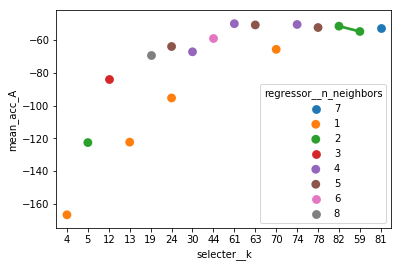

In [12]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\KNeighborsRegressor_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
print(params_df.head())

# plot acc vs. params
params_df = params_df.loc[params_df['regressor__n_neighbors']<10,:] # selecting only lower k
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__n_neighbors', data=sgrid.join(params_df)) 

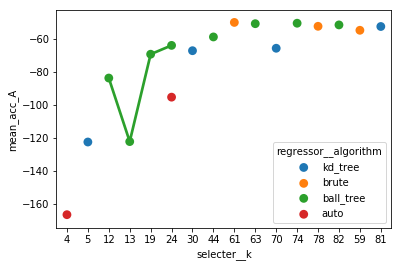

In [13]:
# plot acc vs. params
params_df = params_df.loc[params_df['regressor__n_neighbors']<10,:] # selecting only lower k
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__algorithm', data=sgrid.join(params_df)) 

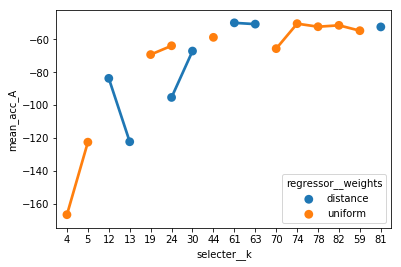

In [14]:
# plot acc vs. params
params_df = params_df.loc[params_df['regressor__n_neighbors']<10,:] # selecting only lower k
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__weights', data=sgrid.join(params_df)) 

From this quick random search, we can see that this is contributing to the error to be lower:

* regressor__algorithm: 'brute' and 'ball_tree' seem to be fine with k>44. Let us stick to 'brute'
* regressor__n_neighbors: 4 or 5 neighbors
* regressor__weights: 'distance' seems to be fine with k>44
* selecter__k: k >= 44

In [45]:

# Fine-tuning KNeighborsRegressor with gridsearch

def get_KNeighborsRegressor2finetune():

    model = KNeighborsRegressor()
    hp = dict(
        regressor__n_neighbors = list(range(3,7)),
        regressor__weights = ['distance'],
        regressor__algorithm = ['brute']
    )
    return 'KNeighborsRegressor', model, hp

# Hyperparameter tuning with this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_KNeighborsRegressor2finetune], 
                           target_trait,
                           feats_names,
                           np.arange(44, AX.shape[1]), 
                           'grid'
                          )

# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'KNeighborsRegressor' -> Best cross-val score on A set: -47.882521 using {'regressor__algorithm': 'brute', 'regressor__n_neighbors': 3, 'regressor__weights': 'distance', 'selecter__k': 84}
'KNeighborsRegressor' -> Selected features:
[["'F0semitoneFrom27.5Hz_sma3nz_amean'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile20.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile50.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_percentile80.0'"], ["'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'"], ["'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'"], ["'loudness_sma3_amean'"], ["'loudness_sma3_stddevNorm'"], ["'loudness_sma3_percentile20.0'"], ["'loudness_sma3_percentile50.0'"], ["'loudness_sma3_percentile80.0'"], ["'loudness_sma3_pctlrange0-2'"], ["'loudness_sma3_meanRisingSlope'"], ["'loudness_sma3_stddevRisingSlop

  regressor__algorithm regressor__n_neighbors regressor__weights selecter__k  \
0                brute                      3           distance          44   
1                brute                      3           distance          45   
2                brute                      3           distance          46   
3                brute                      3           distance          47   
4                brute                      3           distance          48   

       reg_params  
0  brutedistance3  
1  brutedistance3  
2  brutedistance3  
3  brutedistance3  
4  brutedistance3  


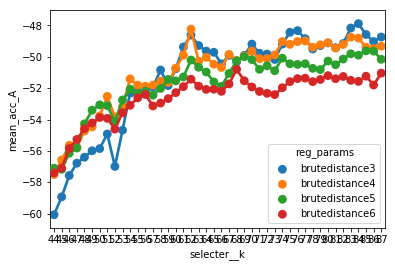

In [46]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\KNeighborsRegressor_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
params_df['reg_params'] = params_df['regressor__algorithm'].values + params_df['regressor__weights'].values + params_df['regressor__n_neighbors'].values.astype(str)
print(params_df.head())

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='reg_params', data=sgrid.join(params_df)) 

After fine-tuning, k=3 outperforms k=4. Root mean_squared_error on B set: 6.46 -> this is similar performance as with random search

#### Support Vector Machines

*class sklearn.svm.SVR(kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)*

Hyperparameter tuning of SVR with different kernels:

For 'rbf': Tuning C (penalty of the error term) and gamma. No feature selection (k = [88]), since SVM should work better with higher number of features.

In [6]:
from sklearn.svm import SVR

"""
Support Vector Machines with linear kernel
"""
def get_SVRlinear2tune():
    
    model = SVR()
    hp = dict(
        regressor__C = np.logspace(-5,2,num=8),
        regressor__kernel = ['linear']
    )
    return 'SVRlinear', model, hp

# tune with linear kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_SVRlinear2tune], 
                           target_trait,
                           feats_names,
                           [88], 
                           'grid'
                          )

# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

'SVRlinear' -> Best cross-val score on A set: -82.511094 using {'regressor__C': 100.0, 'regressor__kernel': 'linear', 'selecter__k': 88}
'SVRlinear' -> root mean_squared_error on B set: 9.264138



Support Vector Machines with rbf kernel. (hp ranges based on a quick random search)

In [14]:
from sklearn.svm import SVR

"""
Support Vector Machines with rbf kernel
"""
def get_SVRrbf2tune():
    
    model = SVR()
    hp = dict(
        regressor__C = np.logspace(-3,1,num=5),
        regressor__kernel = ['rbf'], 
        regressor__gamma = np.logspace(-3,-1,num=3)
    )
    return 'SVRrbf', model, hp


# tune with poly kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_SVRrbf2tune], 
                           target_trait,
                           feats_names,
                           [88], 
                           'grid'
                          )


'SVRrbf' -> Best cross-val score on A set: -59.066775 using {'regressor__C': 10.0, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf', 'selecter__k': 88}
'SVRrbf' -> root mean_squared_error on B set: 7.052087



  regressor__C regressor__gamma regressor__kernel selecter__k
0        0.001            0.001               rbf          88
1        0.001             0.01               rbf          88
2        0.001              0.1               rbf          88
3         0.01            0.001               rbf          88
4         0.01             0.01               rbf          88


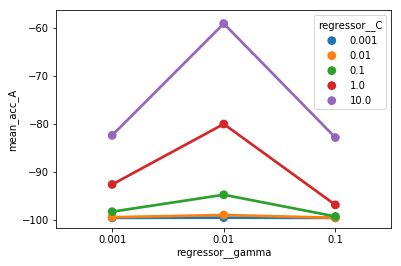

In [15]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\SVRrbf_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
print(params_df.head())

# plot acc vs. params
sns.pointplot(x='regressor__gamma', y='mean_acc_A',hue='regressor__C', data=sgrid.join(params_df)) 

The value gamma = 0.01 and higher complexity seems promising. Let us perform another gridsearch.

In [9]:
from sklearn.svm import SVR

"""
Support Vector Machines with rbf kernel
"""
def get_SVRrbf2tune():
    
    model = SVR()
    hp = dict(
        regressor__C = np.logspace(1,4,num=5),
        regressor__kernel = ['rbf'], 
        regressor__gamma = [0.01]
    )
    return 'SVRrbf', model, hp


# tune with poly kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_SVRrbf2tune], 
                           target_trait,
                           feats_names,
                           [88], 
                           'grid'
                          )

'SVRrbf' -> Best cross-val score on A set: -46.687707 using {'regressor__C': 316.22776601683796, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf', 'selecter__k': 88}
'SVRrbf' -> root mean_squared_error on B set: 6.092025



  regressor__C regressor__gamma regressor__kernel selecter__k
0           10             0.01               rbf          88
1      56.2341             0.01               rbf          88
2      316.228             0.01               rbf          88
3      1778.28             0.01               rbf          88
4        10000             0.01               rbf          88


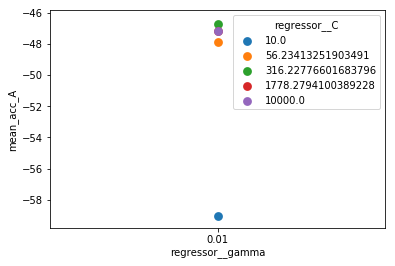

In [10]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\SVRrbf_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
print(params_df.head())

# plot acc vs. params
sns.pointplot(x='regressor__gamma', y='mean_acc_A',hue='regressor__C', data=sgrid.join(params_df)) 

SVRrbf is now well tuned and trained.

In [11]:
# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

In [20]:
from sklearn.svm import SVR

"""
Support Vector Machines with sigmoid kernel
"""
def get_SVRsigmoid2tune():
    
    model = SVR()
    hp = dict(
        regressor__C = np.logspace(-5,3,num=9),
        regressor__kernel = ['sigmoid'],
        regressor__gamma = np.logspace(-5,5,num=11)
    )
    return 'SVRsigmoid', model, hp

# tune with sigmoid kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_SVRsigmoid2tune], 
                           target_trait,
                           feats_names,
                           [88], 
                           'random',
                           n_iter=50
                          )

# # update lists of tuning info and trained regressors
# tuning_all = tuning_all.append(tuning, ignore_index=True)
# trained_all.append(trained)

'SVRsigmoid' -> Best cross-val score on A set: -83.842604 using {'selecter__k': 88, 'regressor__kernel': 'sigmoid', 'regressor__gamma': 0.0001, 'regressor__C': 1000.0}
'SVRsigmoid' -> root mean_squared_error on B set: 9.047092



  regressor__C regressor__gamma regressor__kernel selecter__k
0            1            0.001           sigmoid          88
1         0.01              0.1           sigmoid          88
2           10              100           sigmoid          88
3        1e-05             1000           sigmoid          88
4       0.0001              100           sigmoid          88


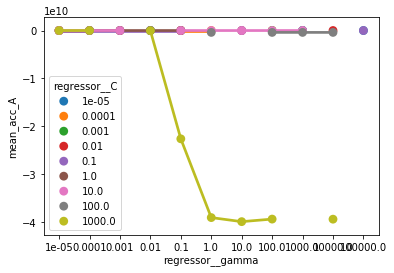

In [21]:
# open generated file with results of fitting RandomizedSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\SVRsigmoid_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
print(params_df.head())

# plot acc vs. params
sns.pointplot(x='regressor__gamma', y='mean_acc_A',hue='regressor__C', data=sgrid.join(params_df)) 

In [ ]:
High C and low gamma tend to provide better results. Let us perform a small gridsearch around those values.

In [23]:
from sklearn.svm import SVR

"""
Support Vector Machines with sigmoid kernel
"""
def get_SVRsigmoid2tune():
    
    model = SVR()
    hp = dict(
        regressor__C = np.logspace(3,4,num=3),
        regressor__kernel = ['sigmoid'],
        regressor__gamma = [0.0001]
    )
    return 'SVRsigmoid', model, hp

# tune with sigmoid kernel
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_SVRsigmoid2tune], 
                           target_trait,
                           feats_names,
                           [88], 
                           'grid'
                          )

# # update lists of tuning info and trained regressors
# tuning_all = tuning_all.append(tuning, ignore_index=True)
# trained_all.append(trained)

'SVRsigmoid' -> Best cross-val score on A set: -83.155657 using {'regressor__C': 10000.0, 'regressor__gamma': 0.0001, 'regressor__kernel': 'sigmoid', 'selecter__k': 88}
'SVRsigmoid' -> root mean_squared_error on B set: 9.254380



  regressor__C regressor__gamma regressor__kernel selecter__k
0         1000           0.0001           sigmoid          88
1      3162.28           0.0001           sigmoid          88
2        10000           0.0001           sigmoid          88


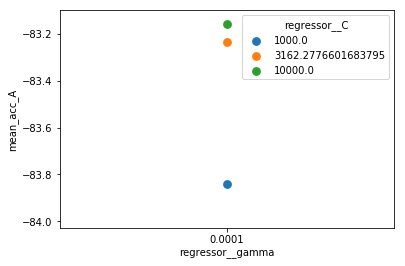

In [24]:
# open generated file with results of fitting GridSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\SVRsigmoid_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
print(params_df.head())

# plot acc vs. params
sns.pointplot(x='regressor__gamma', y='mean_acc_A',hue='regressor__C', data=sgrid.join(params_df)) 

This (better tuned) SVRsigmoid is too complex and does not provide better results than SVRrbf with the same complexity.

In [ ]:
# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, target_trait)

#### Decision tree

*class sklearn.tree.DecisionTreeRegressor(criterion=’mse’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, presort=False)*

Tune: max_depth

In [44]:
from sklearn.tree import DecisionTreeRegressor

"""
Decision Trees
"""
def get_DecisionTreeRegressor2tune():
    
    model = DecisionTreeRegressor(random_state=2302)
    hp = dict(
        regressor__max_depth = np.arange(3,10), 
        regressor__min_samples_split = np.arange(2,20) 
    )
    return 'DecisionTreeRegressor', model, hp


# tune this model
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_DecisionTreeRegressor2tune], 
                           target_trait,
                           feats_names,
                           np.arange(1, AX.shape[1]), 
                           mode='random',
                           n_iter=50
                          )

'DecisionTreeRegressor' -> Best cross-val score on A set: -89.445633 using {'selecter__k': 23, 'regressor__min_samples_split': 7, 'regressor__max_depth': 4}
'DecisionTreeRegressor' -> root mean_squared_error on B set: 9.221154



   regressor__max_depth  regressor__min_samples_split  selecter__k
0                     8                            16           81
1                     3                            19           60
2                     3                            19           71
3                     3                             4           38
4                     6                            18           39


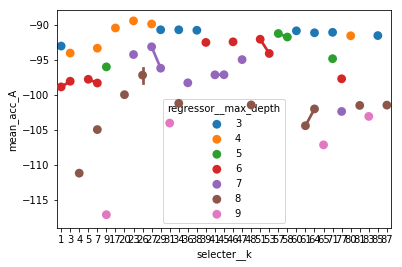

In [45]:
# open generated file with results of fitting RandomizedSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\DecisionTreeRegressor_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
print(params_df.head())

# plot acc vs. params
sns.pointplot(x='selecter__k', y='mean_acc_A',hue='regressor__max_depth', data=sgrid.join(params_df)) 

In [46]:
# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, target_trait)

max_depth~3 or 4 and low number of features seem to work better. Performance still not very good.

#### Random Forest

*class sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)*

Tune: max_depth, min_samples_leaf. Max features taken are those given by the feature selection method.

In [18]:
from sklearn.ensemble import RandomForestRegressor

"""
Random Forest
"""
def get_RandomForestRegressor2tune():
    
    model = RandomForestRegressor(random_state=2302, max_features = None)
    hp = dict(
        regressor__max_depth = np.arange(30,60), 
        regressor__min_samples_leaf = np.arange(2,10) 
    )
    return 'RandomForestRegressor', model, hp

# feature selection
k_array = np.arange(30, 70)

# tune this model (multiputput)
tuning, trained = hp_tuner(AX, BX, Ay, By, 
                           [get_RandomForestRegressor2tune], 
                           target_trait,
                           feats_names,
                           k_array, 
                           mode='random',
                           n_iter=50
                          )

'RandomForestRegressor' -> Best cross-val score on A set: -66.152647 using {'selecter__k': 62, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 55}
'RandomForestRegressor' -> root mean_squared_error on B set: 7.626334



   regressor__max_depth  regressor__min_samples_leaf  selecter__k
0                    35                            9           59
1                    48                            4           50
2                    37                            4           68
3                    59                            8           59
4                    44                            2           52


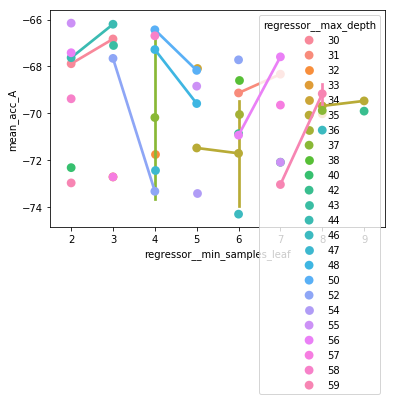

In [19]:
# open generated file with results of fitting RandomizedSearchCV

sgrid = pd.read_csv(r'.\data_while_tuning\RandomForestRegressor_'+target_trait+'_tuning.csv')

# params to dataframe
params_dict = sgrid['params'].apply(lambda x: literal_eval(x) ).to_dict()
params_df = pd.DataFrame(data = params_dict).transpose()
print(params_df.head())

# plot acc vs. params
sns.pointplot(x='regressor__min_samples_leaf', y='mean_acc_A',hue='regressor__max_depth', data=sgrid.join(params_df)) 

After a couple of random searches, rmse on B is still around 7.6.

In [20]:
# update lists of tuning info and trained regressors
tuning_all = tuning_all.append(tuning, ignore_index=True)
trained_all.append(trained)

# save tuning_all (.csv) and trained_all (nameregressor.sav)
save_tuning(tuning_all, trained_all, target_trait)

## Testing

### RMSE
Testing the best model found after hyperparameter tuning.

Performance metric: RMSE (see above).
    
The predictions correspond to the scores of each test segment (3 parts x 4 dialogs) spoken by the same test speaker. I perform the average of the predicted ratings that correspond to the same speaker - to be compared to the true ratings.

In [14]:
tuning_all

,best_accs,best_hps,regressors_names,sel_feats,sel_feats_i
0,9.146486,{'selecter__k': 87},LinearRegression,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True True True True True True Tr...
1,9.060913,{'selecter__k': 68},ElasticNet,"[[""'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'""],...",[False True True False True True True Tr...
2,6.334999,"{'selecter__k': 61, 'regressor__weights': 'dis...",KNeighborsRegressor,"[[""'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'""],...",[False True True False True True True Fal...
3,6.464051,"{'regressor__algorithm': 'brute', 'regressor__...",KNeighborsRegressor,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True True True True True True Tr...
4,9.264138,"{'regressor__C': 100.0, 'regressor__kernel': '...",SVClinear,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True True True True True True Tr...
5,6.092025,"{'regressor__C': 316.22776601683796, 'regresso...",SVRrbf,"[[""'F0semitoneFrom27.5Hz_sma3nz_amean'""], [""'F...",[ True True True True True True True Tr...
6,9.221154,"{'selecter__k': 23, 'regressor__min_samples_sp...",DecisionTreeRegressor,"[[""'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'""],...",[False True False False False True False Fal...
7,7.626334,"{'selecter__k': 62, 'regressor__min_samples_le...",RandomForestRegressor,"[[""'F0semitoneFrom27.5Hz_sma3nz_stddevNorm'""],...",[False True True False True True True Tr...


In [7]:
# select the classifier that gave the maximum acc on B set
best_accs = tuning_all['best_accs']
i_best = best_accs.idxmin()

print('Selected classifier based on the best performance on B: %r (perf. on B = %0.2f)' % (tuning_all.loc[i_best,'regressors_names'], round(best_accs[i_best],2)))

Selected classifier based on the best performance on B: 'SVRrbf' (perf. on B = 6.09)


In [8]:
# compute predictions with the best tuned regressor

yt_pred = trained_all[i_best][0].predict(Xt)


In [18]:
# average of outputs that belong to the same speaker

test_scores = pd.DataFrame(data = feats_ratings_test[[target_trait,'spkID']])
test_scores['pred'] = yt_pred

test_scores_avg = test_scores.groupby('spkID').mean()

myrmse = np.sqrt(mean_squared_error(test_scores[target_trait].as_matrix(), 
             test_scores['pred'].as_matrix()))

myrmse_avg = np.sqrt(mean_squared_error(test_scores_avg[target_trait].as_matrix(), 
             test_scores_avg['pred'].as_matrix()))

print('RMSE per instance: %0.2f' % myrmse)   
print('RMSE after averaging over speaker utterances: %0.2f' % myrmse_avg)    

print(test_scores_avg)

RMSE per instance: 10.78
RMSE after averaging over speaker utterances: 9.73
       non_likable       pred
spkID                        
1        36.571429  48.793348
9        40.500000  45.279881
11       39.466667  43.855061
18       43.500000  39.399135
22       58.466667  52.507244
25       41.250000  48.662647
28       63.800000  45.903683
32       57.941176  41.818062
33       60.500000  45.335919
35       34.352941  39.901689
38       29.062500  42.925633
51       48.437500  46.129525
53       55.750000  54.883074
55       35.733333  43.196187
57       40.066667  40.867028
65       39.266667  47.619009
66       44.875000  51.738689
67       49.733333  48.480670
80       42.312500  40.298916
87       36.764706  40.730721
92       51.750000  43.653303
93       42.812500  38.668328
94       68.333333  49.551773
105      67.600000  45.847028
107      60.235294  55.597525
108      57.357143  43.654327
113      45.875000  45.463421
114      44.846154  44.706938
118      30.200000  37.7

Let us examine the RMSE across all trained regressors:

In [22]:
# go through performace ofor all regressors

# removing duplicates from tuning_all (same classifier tuned twice with different searchers)
indexes = tuning_all['regressors_names'].drop_duplicates(keep='last').index.values

# dataframe for summary of performances
performances = pd.DataFrame(tuning_all.loc[indexes,['regressors_names','best_accs']])

for i in indexes:

    yt_pred = trained_all[i][0].predict(Xt)
        
    # average of outputs that belong to the same speaker

    test_scores = pd.DataFrame(data = feats_ratings_test[[target_trait,'spkID']])
    test_scores['pred'] = yt_pred

    test_scores_avg = test_scores.groupby('spkID').mean()

    myrmse = np.sqrt(mean_squared_error(test_scores[target_trait].as_matrix(), 
                 test_scores['pred'].as_matrix()))

    myrmse_avg = np.sqrt(mean_squared_error(test_scores_avg[target_trait].as_matrix(), 
                 test_scores_avg['pred'].as_matrix()))

    print('"%r -> RMSE per instance on B: %0.2f' % (tuning_all.loc[i,'regressors_names'], tuning_all.loc[i,'best_accs']))   
    print('"%r -> RMSE per instance: %0.2f' % (tuning_all.loc[i,'regressors_names'], myrmse))   
    print('"%r -> RMSE after averaging over speaker utterances: %0.2f' % (tuning_all.loc[i,'regressors_names'], myrmse_avg))   


"'LinearRegression' -> RMSE per instance on B: 9.15
"'LinearRegression' -> RMSE per instance: 9.83
"'LinearRegression' -> RMSE after averaging over speaker utterances: 9.31
"'ElasticNet' -> RMSE per instance on B: 9.06
"'ElasticNet' -> RMSE per instance: 10.46
"'ElasticNet' -> RMSE after averaging over speaker utterances: 10.39
"'KNeighborsRegressor' -> RMSE per instance on B: 6.46
"'KNeighborsRegressor' -> RMSE per instance: 11.28
"'KNeighborsRegressor' -> RMSE after averaging over speaker utterances: 10.00
"'SVClinear' -> RMSE per instance on B: 9.26
"'SVClinear' -> RMSE per instance: 10.14
"'SVClinear' -> RMSE after averaging over speaker utterances: 9.52
"'SVRrbf' -> RMSE per instance on B: 6.09
"'SVRrbf' -> RMSE per instance: 10.78
"'SVRrbf' -> RMSE after averaging over speaker utterances: 9.73
"'DecisionTreeRegressor' -> RMSE per instance on B: 9.22
"'DecisionTreeRegressor' -> RMSE per instance: 10.73
"'DecisionTreeRegressor' -> RMSE after averaging over speaker utterances: 10.11

The baseline regressor would be predict the mean rating of all instances. The RMSE would then be .

In [29]:
yt_pred = np.mean(yt)

# average of outputs that belong to the same speaker

test_scores = pd.DataFrame(data = feats_ratings_test[[target_trait,'spkID']])
test_scores['pred'] = yt_pred

test_scores_avg = test_scores.groupby('spkID').mean()

myrmse = np.sqrt(mean_squared_error(test_scores[target_trait].as_matrix(), 
 test_scores['pred'].as_matrix()))

myrmse_avg = np.sqrt(mean_squared_error(test_scores_avg[target_trait].as_matrix(), 
 test_scores_avg['pred'].as_matrix()))

print('"%r -> RMSE per instance: %0.2f' % ('baseline', myrmse))   
print('"%r -> RMSE after averaging over speaker utterances: %0.2f' % ('baseline', myrmse_avg)) 
 

"'baseline' -> RMSE per instance: 10.72
"'baseline' -> RMSE after averaging over speaker utterances: 10.67


The predictions with the different regressors just slightly improve the baseline. SVRrbf and KNeighborsRegressor are overfitted.